In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


def set_all_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
seed = 0
set_all_seed(seed=seed)

Using device: cuda


In [6]:
# Paths
# TRAIN_DIR = './cosmic-curator/train_images'
# TEST_DIR = './cosmic-curator/test_images'
# TRAIN_CSV = './cosmic-curator/train2.csv'

TRAIN_DIR = '/kaggle/input/cosmic-curator/train_images_updated/train_images_updated'
TEST_DIR = '/kaggle/input/cosmic-curator/test_images/test_images'
TRAIN_CSV = '/kaggle/input/cosmic-curator/train_images_updated.csv'
OUT_DIR = './results'
if os.path.exists(OUT_DIR):
    import shutil
    shutil.rmtree(OUT_DIR)
# create directory
os.makedirs(OUT_DIR, exist_ok=True)
OUT_TRAIN_CSV = os.path.join(OUT_DIR, 'train.csv')
OUT_TEST_CSV = os.path.join(OUT_DIR, 'test.csv')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
BATCH_SIZE = 32
# BATCH_SIZE = 16
NUM_CLASSES = 3
NUM_EPOCHS = 30
LEARNING_RATE = 3e-5
IMG_SIZE = 224
VAL_SPLIT = 0.1
SAVE_CHECKPOINT = True

In [ ]:
# --- Custom Dataset ---
class GalaxyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        asset_id = self.df.loc[idx, 'asset_id']
        img_path = os.path.join(self.img_dir, f"{asset_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, asset_id
        else:
            label = int(self.df.loc[idx, 'GalaxyType'])
            return image, label

In [ ]:
# # --- Transforms ---

# # Resnet Transforms
# train_transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# # SwinT Transforms
weights = models.Swin_T_Weights.DEFAULT
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [8]:
# --- Load CSV ---
train_df = pd.read_csv(TRAIN_CSV)
print("Images in train set:", len(train_df))
# delete the images that are not in the train set
train_img_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TRAIN_DIR) if f.endswith('.jpg')]
train_df = train_df[train_df['asset_id'].isin(train_img_asset_ids)]
train_df = train_df.reset_index(drop=True)

test_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TEST_DIR) if f.endswith('.jpg')]
test_df = pd.DataFrame({'asset_id': test_asset_ids})
print("Images in test set:", len(test_df))


# --- Train/Val Split ---
train_df, val_df = train_test_split(train_df, test_size=VAL_SPLIT, stratify=train_df['GalaxyType'], random_state=seed)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("After splitting into train and val sets:")
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Images in train set: 5994
Images in test set: 412
After splitting into train and val sets:
Train size: 5394
Val size: 600
Test size: 412


In [9]:
# class counts
print("Train class counts:")
print(train_df['GalaxyType'].value_counts())
print("Val class counts:")
print(val_df['GalaxyType'].value_counts())

Train class counts:
GalaxyType
2    2952
0    1637
1     805
Name: count, dtype: int64
Val class counts:
GalaxyType
2    328
0    182
1     90
Name: count, dtype: int64


In [10]:
train_dataset = GalaxyDataset(train_df, TRAIN_DIR, transform=train_transform)
val_dataset = GalaxyDataset(val_df, TRAIN_DIR, transform=test_transform)
test_dataset = GalaxyDataset(test_df, TEST_DIR, transform=test_transform, is_test=True)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset)) 
print("Test dataset size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train dataset size: 5394
Validation dataset size: 600
Test dataset size: 412
Train loader size: 169
Validation loader size: 19
Test loader size: 13


In [ ]:
# # --- Model ---
# Resnet18
# model = models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 3)
# )

# Swin Transformer
weights = models.Swin_T_Weights.DEFAULT
model = models.swin_t(weights=weights)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 90.2MB/s] 


In [12]:
# --- Training Loop ---
# Initialize lists to store F1 scores
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []

best_val_f1 = 0.0  # To track the best validation F1 score
best_model_path = os.path.join(OUT_DIR, 'best_model.pth')

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(train_labels, train_preds, average='macro')
    train_f1_scores.append(train_f1)
    train_losses.append(train_loss / len(train_loader))  # Average train loss

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_losses.append(val_loss / len(val_loader))  # Average validation loss

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train F1={train_f1:.4f}, Val Loss={val_losses[-1]:.4f}, Val F1={val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with Val F1={best_val_f1:.4f}")

    # Save checkpoint for each epoch if enabled
    # if SAVE_CHECKPOINT and (epoch + 1) % 5 == 0:
    if SAVE_CHECKPOINT:
        checkpoint_path = os.path.join(OUT_DIR, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)

Epoch 1 [Val]: 100%|██████████| 19/19 [00:06<00:00,  2.73it/s]


Epoch 1: Train Loss=0.7002, Train F1=0.6051, Val Loss=0.5973, Val F1=0.7038
✅ Best model saved with Val F1=0.7038


Epoch 2 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s]


Epoch 2: Train Loss=0.5673, Train F1=0.7198, Val Loss=0.5696, Val F1=0.7240
✅ Best model saved with Val F1=0.7240


Epoch 3 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.63it/s]


Epoch 3: Train Loss=0.5333, Train F1=0.7330, Val Loss=0.5932, Val F1=0.6942


Epoch 4 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]


Epoch 4: Train Loss=0.5199, Train F1=0.7420, Val Loss=0.5700, Val F1=0.7298
✅ Best model saved with Val F1=0.7298


Epoch 5 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]


Epoch 5: Train Loss=0.4866, Train F1=0.7660, Val Loss=0.5260, Val F1=0.7453
✅ Best model saved with Val F1=0.7453


Epoch 6 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]


Epoch 6: Train Loss=0.4717, Train F1=0.7745, Val Loss=0.5165, Val F1=0.7458
✅ Best model saved with Val F1=0.7458


Epoch 7 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.58it/s]


Epoch 7: Train Loss=0.4558, Train F1=0.7844, Val Loss=0.5224, Val F1=0.7594
✅ Best model saved with Val F1=0.7594


Epoch 8 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]


Epoch 8: Train Loss=0.4378, Train F1=0.7879, Val Loss=0.5568, Val F1=0.7215


Epoch 9 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s]


Epoch 9: Train Loss=0.4263, Train F1=0.7984, Val Loss=0.5194, Val F1=0.7533


Epoch 10 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


Epoch 10: Train Loss=0.4139, Train F1=0.8038, Val Loss=0.5113, Val F1=0.7550


Epoch 11 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.61it/s]


Epoch 11: Train Loss=0.3936, Train F1=0.8106, Val Loss=0.5236, Val F1=0.7623
✅ Best model saved with Val F1=0.7623


Epoch 12 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]


Epoch 12: Train Loss=0.3858, Train F1=0.8178, Val Loss=0.5320, Val F1=0.7489


Epoch 13 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.64it/s]


Epoch 13: Train Loss=0.3651, Train F1=0.8248, Val Loss=0.5596, Val F1=0.7581


Epoch 14 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.47it/s]


Epoch 14: Train Loss=0.3666, Train F1=0.8263, Val Loss=0.5670, Val F1=0.7633
✅ Best model saved with Val F1=0.7633


Epoch 15 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.58it/s]


Epoch 15: Train Loss=0.3298, Train F1=0.8468, Val Loss=0.6048, Val F1=0.7599


Epoch 16 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]


Epoch 16: Train Loss=0.3288, Train F1=0.8512, Val Loss=0.5569, Val F1=0.7676
✅ Best model saved with Val F1=0.7676


Epoch 17 [Val]: 100%|██████████| 19/19 [00:03<00:00,  4.76it/s]


Epoch 17: Train Loss=0.3003, Train F1=0.8604, Val Loss=0.6861, Val F1=0.7455


Epoch 18 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.65it/s]


Epoch 18: Train Loss=0.3049, Train F1=0.8604, Val Loss=0.6853, Val F1=0.7476


Epoch 19 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.41it/s]


Epoch 19: Train Loss=0.2872, Train F1=0.8695, Val Loss=0.7530, Val F1=0.7657


Epoch 20 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.47it/s]


Epoch 20: Train Loss=0.2693, Train F1=0.8780, Val Loss=0.7164, Val F1=0.7530


Epoch 21 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


Epoch 21: Train Loss=0.2597, Train F1=0.8791, Val Loss=0.7127, Val F1=0.7512


Epoch 22 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.58it/s]


Epoch 22: Train Loss=0.2469, Train F1=0.8896, Val Loss=0.7403, Val F1=0.7377


Epoch 23 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.61it/s]


Epoch 23: Train Loss=0.2385, Train F1=0.8949, Val Loss=0.7624, Val F1=0.7596


Epoch 24 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]


Epoch 24: Train Loss=0.2237, Train F1=0.8937, Val Loss=0.7143, Val F1=0.7575


Epoch 25 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.57it/s]


Epoch 25: Train Loss=0.2173, Train F1=0.8964, Val Loss=0.7696, Val F1=0.7399


Epoch 26 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]


Epoch 26: Train Loss=0.1969, Train F1=0.9114, Val Loss=0.8936, Val F1=0.7441


Epoch 27 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]


Epoch 27: Train Loss=0.1957, Train F1=0.9080, Val Loss=0.8045, Val F1=0.7386


Epoch 28 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.64it/s]


Epoch 28: Train Loss=0.1876, Train F1=0.9162, Val Loss=0.8939, Val F1=0.7470


Epoch 29 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.74it/s]


Epoch 29: Train Loss=0.1692, Train F1=0.9239, Val Loss=1.0939, Val F1=0.7416


Epoch 30 [Val]: 100%|██████████| 19/19 [00:04<00:00,  4.46it/s]


Epoch 30: Train Loss=0.1678, Train F1=0.9237, Val Loss=0.8354, Val F1=0.7360


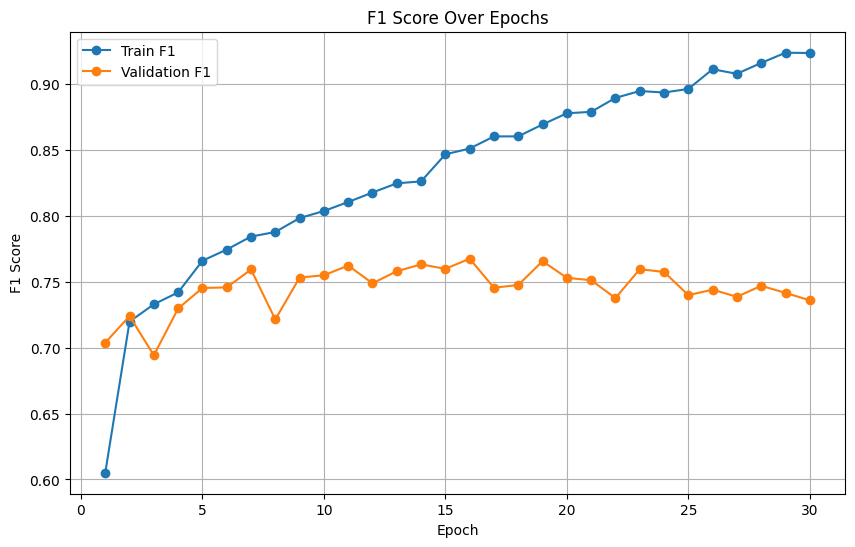

✅ F1 score plot saved at ./results/f1_scores_plot.png


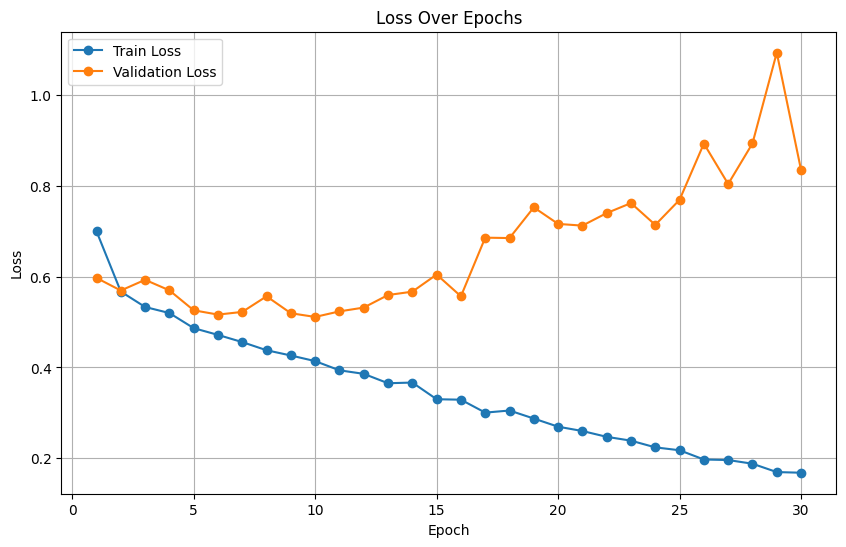

✅ Loss plot saved at ./results/losses_plot.png


In [13]:
# --- Plot F1 Scores ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores, label='Train F1', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_f1_scores, label='Validation F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'f1_scores_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ F1 score plot saved at {plot_path}")

# --- Plot Losses ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'losses_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ Loss plot saved at {plot_path}")

In [ ]:
# # load best model
# # Resnet18
# model = models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 3)
# )

# # Swin Transformer
model = models.swin_t(weights=weights)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(DEVICE)
best_model_path = os.path.join(OUT_DIR, 'model_epoch_14.pth')
model.load_state_dict(torch.load(best_model_path, weights_only=True))


<All keys matched successfully>

In [25]:
# --- Test Prediction ---
model.eval()
predictions = []
asset_ids = []

with torch.no_grad():
    for images, ids in tqdm(test_loader, desc="Predicting"):
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        predictions.extend(preds)
        asset_ids.extend(ids.cpu().numpy())  # Convert tensor to numpy array and extend

# --- Save Submission ---
submission_df = pd.DataFrame({'id': asset_ids, 'GalaxyType': predictions})
submission_df.sort_values('id', inplace=True)
submission_df.to_csv(OUT_TEST_CSV, index=False)
print(f"Submission saved to {OUT_TEST_CSV}")
print(submission_df.head())


Predicting: 100%|██████████| 13/13 [00:02<00:00,  4.87it/s]

Submission saved to ./results/test.csv
     id  GalaxyType
133   1           2
398   2           0
348   3           2
336   4           2
35    5           0
